# Imports & Libraries

In [2488]:
import sys
sys.path.append('..')
import random
import numpy as np
import pandas as pd
from copy import deepcopy
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import importlib
import copy
import math

# Load the Data

In [2489]:
# Load the data from the Excel file
df = pd.read_excel('players.xlsx')

# Extract player data
players = []
for _, row in df.iterrows():
    players.append((row['Name'], row['Position'], row['Skill'], row['Salary (â‚¬M)']))

In [2490]:
df = pd.DataFrame(players, columns=['Player Name', 'Position', 'Rating', 'Cost'])
print(df)

         Player Name Position  Rating  Cost
0        Alex Carter       GK      85    90
1       Jordan Smith       GK      88   100
2      Ryan Mitchell       GK      83    85
3     Chris Thompson       GK      80    80
4    Blake Henderson       GK      87    95
5      Daniel Foster      DEF      90   110
6      Lucas Bennett      DEF      85    90
7        Owen Parker      DEF      88   100
8       Ethan Howard      DEF      80    70
9         Mason Reed      DEF      82    75
10      Logan Brooks      DEF      86    95
11      Caleb Fisher      DEF      84    85
12     Nathan Wright      MID      92   120
13      Connor Hayes      MID      89   105
14      Dylan Morgan      MID      91   115
15     Hunter Cooper      MID      83    85
16     Austin Torres      MID      82    80
17  Gavin Richardson      MID      87    95
18      Spencer Ward      MID      84    85
19   Sebastian Perry      FWD      95   150
20     Xavier Bryant      FWD      90   120
21    Elijah Sanders      FWD   

# Problem Definition

``Sports League Optimization``

**Objective** - Assign  players  to  teams according to specified positions in  a  way  that  ensures a balanced distribution of talent while staying within salary caps. (5 teams, 7 players each)

**Players** - Defined by a set of attributes that include:
- Skill rating: Represents the player's ability/talent. 
- Cost: The player's salary (in milions). 
- Position: Goalkeeper  (GK),  Defender  (DEF),  Midfielder  (MID),  or 
    Forward (FWD). 

**Constraints** - An object is considered a solution if it complies with these conditions:
- Each team must consist of: 1 Goalkeeper, 2 Defenders, 2 Midfielders and 2 Forwards. 
- Each player is assigned to exactly one team.
- All teams must be complete.
- Each team should not exceed a 750€ million total budget. 
- The average skill rating of the players should be roughly the same among the teams.


# Data Exploration

In [2491]:
print(f"This dataset contains {len(df)} players.")
players

This dataset contains 35 players.


[('Alex Carter', 'GK', 85, 90),
 ('Jordan Smith', 'GK', 88, 100),
 ('Ryan Mitchell', 'GK', 83, 85),
 ('Chris Thompson', 'GK', 80, 80),
 ('Blake Henderson', 'GK', 87, 95),
 ('Daniel Foster', 'DEF', 90, 110),
 ('Lucas Bennett', 'DEF', 85, 90),
 ('Owen Parker', 'DEF', 88, 100),
 ('Ethan Howard', 'DEF', 80, 70),
 ('Mason Reed', 'DEF', 82, 75),
 ('Logan Brooks', 'DEF', 86, 95),
 ('Caleb Fisher', 'DEF', 84, 85),
 ('Nathan Wright', 'MID', 92, 120),
 ('Connor Hayes', 'MID', 89, 105),
 ('Dylan Morgan', 'MID', 91, 115),
 ('Hunter Cooper', 'MID', 83, 85),
 ('Austin Torres', 'MID', 82, 80),
 ('Gavin Richardson', 'MID', 87, 95),
 ('Spencer Ward', 'MID', 84, 85),
 ('Sebastian Perry', 'FWD', 95, 150),
 ('Xavier Bryant', 'FWD', 90, 120),
 ('Elijah Sanders', 'FWD', 93, 140),
 ('Adrian Collins', 'FWD', 85, 90),
 ('Tyler Jenkins', 'FWD', 80, 70),
 ('Chase Murphy', 'FWD', 86, 95),
 ('Landon Powell', 'FWD', 89, 110),
 ('Julian Scott', 'FWD', 92, 130),
 ('Bentley Rivera', 'MID', 88, 100),
 ('Maxwell Flores'

In [2492]:
num_duplicates = df.duplicated().sum()
print(f"There are {num_duplicates} duplicate rows.")

There are 0 duplicate rows.


In [2493]:
print(f"There are {df['Position'].nunique()} unique positions in the dataset.")
df['Position'].value_counts()

There are 4 unique positions in the dataset.


DEF    10
MID    10
FWD    10
GK      5
Name: Position, dtype: int64

In [2494]:
df['Rating'].describe()

count    35.000000
mean     86.400000
std       4.095909
min      79.000000
25%      83.500000
50%      86.000000
75%      89.500000
max      95.000000
Name: Rating, dtype: float64

Player ratings vary from 79 to 95. The average rating is 86.4.

In [2495]:
df['Cost'].describe()

count     35.000000
mean      97.828571
std       19.876805
min       65.000000
25%       85.000000
50%       95.000000
75%      110.000000
max      150.000000
Name: Cost, dtype: float64

Players costs vary from 65€ million to 150€ million. The average cost for a player is ~98€ million.

# Solution Implementation

##### ``Constants``

In [2496]:
# Constants
NUM_TEAMS = 5
PLAYERS_PER_TEAM = 7
MAX_BUDGET = 750  # Million €
POSITION_REQUIREMENTS = {"GK": 1, "DEF": 2, "MID": 2, "FWD": 2}

##### ``Solution Class (League Configuration)``

In [2497]:
class TeamAssignmentSolution:
    def __init__(self, players, population=None):
        self.players = players  # List of (name, position, skill, cost)
        self.population = population if population else {}

    def random_initial_representation(self, max_attempts=1000):
        """Randomly create a valid team assignment representation."""
        for attempt in range(max_attempts):
            teams = {i: {"GK": [], "DEF": [], "MID": [], "FWD": [], "total_cost": 0} for i in range(NUM_TEAMS)}
            assigned_players = set()
            shuffled_players = random.sample(self.players, len(self.players))

            for player in shuffled_players:
                name, position, skill, cost = player
                for team_id in sorted(teams, key=lambda tid: teams[tid]["total_cost"]):
                    team = teams[team_id]
                    if len(team[position]) < POSITION_REQUIREMENTS[position] and team["total_cost"] + cost <= MAX_BUDGET:
                        team[position].append(player)
                        team["total_cost"] += cost
                        assigned_players.add(name)
                        break  # Move to next player
                # If no team could take the player, we skip to next (will check validity below)

            # Validate result
            valid_teams = True
            for team in teams.values():
                total_players = sum(len(team[pos]) for pos in POSITION_REQUIREMENTS)
                if total_players != PLAYERS_PER_TEAM:
                    valid_teams = False
                    break
                for pos, required_count in POSITION_REQUIREMENTS.items():
                    if len(team[pos]) != required_count:
                        valid_teams = False
                        break

            if valid_teams and len(assigned_players) == len(self.players):
                self.population = teams
                return self.population

        raise ValueError("Failed to generate a valid team assignment after many attempts.")

    def fitness(self):
        """Evaluate team balance: lower standard deviation of average skill means better balance."""
        if not self.population:
            raise ValueError("Population not initialized. Run random_initial_representation() first.")

        team_avg_skills = []

        for team in self.population.values():
            total_skill = 0
            total_players = 0
            for position in POSITION_REQUIREMENTS:
                for player in team[position]:
                    total_skill += player[2]  # Skill
                    total_players += 1
            avg_skill = total_skill / total_players if total_players > 0 else 0
            team_avg_skills.append(avg_skill)

        return np.std(team_avg_skills)  # Lower is better (balanced teams)


    def print_teams(self):
        for i, team in self.population.items():
            total_skill = 0
            total_players = 0

            for position in ["GK", "DEF", "MID", "FWD"]:
                total_skill += sum(player[2] for player in team[position])
                total_players += len(team[position])

            avg_skill = total_skill / total_players if total_players > 0 else 0

            print(f"\nTeam {i + 1} (Total Cost: {team['total_cost']}M, Average Skill: {avg_skill:.2f})")
            for position in ["GK", "DEF", "MID", "FWD"]:
                for player in team[position]:
                    name, pos, skill, cost = player
                    print(f"  {name} - {pos} | Skill: {skill}, Cost: {cost}M")


    def clone(self):
        """Deep clone the instance and its population"""
        clone = TeamAssignmentSolution(self.players)
        clone.population = copy.deepcopy(self.population)  # Assuming population is a dictionary or list
        return clone


In [2498]:
solution = TeamAssignmentSolution(players)
solution.random_initial_representation()

{0: {'GK': [('Alex Carter', 'GK', 85, 90)],
  'DEF': [('Mason Reed', 'DEF', 82, 75), ('Lucas Bennett', 'DEF', 85, 90)],
  'MID': [('Hunter Cooper', 'MID', 83, 85), ('Nathan Wright', 'MID', 92, 120)],
  'FWD': [('Julian Scott', 'FWD', 92, 130), ('Landon Powell', 'FWD', 89, 110)],
  'total_cost': 700},
 1: {'GK': [('Ryan Mitchell', 'GK', 83, 85)],
  'DEF': [('Logan Brooks', 'DEF', 86, 95), ('Daniel Foster', 'DEF', 90, 110)],
  'MID': [('Dylan Morgan', 'MID', 91, 115), ('Dominic Bell', 'MID', 86, 95)],
  'FWD': [('Chase Murphy', 'FWD', 86, 95), ('Tyler Jenkins', 'FWD', 80, 70)],
  'total_cost': 665},
 2: {'GK': [('Jordan Smith', 'GK', 88, 100)],
  'DEF': [('Jaxon Griffin', 'DEF', 79, 65), ('Ethan Howard', 'DEF', 80, 70)],
  'MID': [('Connor Hayes', 'MID', 89, 105),
   ('Ashton Phillips', 'MID', 90, 110)],
  'FWD': [('Elijah Sanders', 'FWD', 93, 140),
   ('Adrian Collins', 'FWD', 85, 90)],
  'total_cost': 680},
 3: {'GK': [('Blake Henderson', 'GK', 87, 95)],
  'DEF': [('Owen Parker', 'DEF'

##### ``Fitness``

In optimization problems, "fitness" is a measure of how good the solution is based on certain criteria. For our approach, we will assess fitness based on the average skill rating of the players on the 5 teams. This will be stored as their skill rating's standard deviation and from now on we intend on gradually improving our teams by swapping players between them to decrease the fitness score (as in a minimization problem).

In [2499]:
# Evaluate the fitness of the initial population
fitness_score = solution.fitness()
print(f"Fitness Score: {fitness_score}")
solution.print_teams()

Fitness Score: 0.5299210568854696

Team 1 (Total Cost: 700M, Average Skill: 86.86)
  Alex Carter - GK | Skill: 85, Cost: 90M
  Mason Reed - DEF | Skill: 82, Cost: 75M
  Lucas Bennett - DEF | Skill: 85, Cost: 90M
  Hunter Cooper - MID | Skill: 83, Cost: 85M
  Nathan Wright - MID | Skill: 92, Cost: 120M
  Julian Scott - FWD | Skill: 92, Cost: 130M
  Landon Powell - FWD | Skill: 89, Cost: 110M

Team 2 (Total Cost: 665M, Average Skill: 86.00)
  Ryan Mitchell - GK | Skill: 83, Cost: 85M
  Logan Brooks - DEF | Skill: 86, Cost: 95M
  Daniel Foster - DEF | Skill: 90, Cost: 110M
  Dylan Morgan - MID | Skill: 91, Cost: 115M
  Dominic Bell - MID | Skill: 86, Cost: 95M
  Chase Murphy - FWD | Skill: 86, Cost: 95M
  Tyler Jenkins - FWD | Skill: 80, Cost: 70M

Team 3 (Total Cost: 680M, Average Skill: 86.29)
  Jordan Smith - GK | Skill: 88, Cost: 100M
  Jaxon Griffin - DEF | Skill: 79, Cost: 65M
  Ethan Howard - DEF | Skill: 80, Cost: 70M
  Connor Hayes - MID | Skill: 89, Cost: 105M
  Ashton Phillips 

# Selection Mechanism

``Selection Mechanisms`` plays a crucial role in determining which solutions will be passed on to the next generation for our evolutionary algorithm. In this context, it is responsible for choosing which team assignments should undergo further modification to evolve to better solutions. The best solutiond will be more likely to be retained and refined, while less optimal solutions are less likely to survive.

##### `Ranking Selection`

The solutions with better fitness (lower fitness scores in a minimization problem) should be selected more frequently, as their ranks will be higher.

In [2500]:
def ranking_selection(population: list, maximization: bool = False):
    """Ranking selection with fitness-based sorting and rank-weighted probabilities."""

    # Sort individuals based on fitness
    sorted_population = sorted(population, key=lambda ind: ind.fitness(), reverse=maximization)

    # Assign ranks: rank 1 = best, rank N = worst
    ranks = list(range(len(sorted_population), 0, -1))  # Higher rank = higher selection chance

    # Convert ranks to probabilities
    total_rank = sum(ranks)
    probabilities = [rank / total_rank for rank in ranks]

    # Roulette-wheel selection
    random_nr = random.uniform(0, 1)
    cumulative_prob = 0

    for idx, prob in enumerate(probabilities):
        cumulative_prob += prob
        if random_nr <= cumulative_prob:
            return deepcopy(sorted_population[idx])

##### `Tournament Selection`

Since the individuals are randomly chosen, the frequency distribution will depend on the tournament size and randomness of the selections.

In [2501]:
def tournament_selection(population: list, tournament_size: int = 3, maximization: bool = False):
    """Tournament Selection (Always select the best individual)"""

    # Randomly select a subset of individuals (tournament size)
    tournament_individuals = random.sample(population, tournament_size)

    # Sort the tournament individuals by fitness
    # For maximization: best individual has highest fitness
    # For minimization: best individual has lowest fitness
    if maximization:
        best_individual = max(tournament_individuals, key=lambda ind: ind.fitness())  # Select best for maximization
    else:
        best_individual = min(tournament_individuals, key=lambda ind: ind.fitness())  # Select best for minimization

    return deepcopy(best_individual)  # Return the best individual from the tournament

##### `Selection Results`

In [2502]:
def test_selection():
    # Create a small population of TeamAssignmentSolution instances
    population = [TeamAssignmentSolution(players) for _ in range(10)]

    # Ensure that each individual has been initialized properly
    for i, sol in enumerate(population):
        sol.random_initial_representation()
        print(f"Solution {i+1} - Fitness: {sol.fitness()}")

    # Run the selection process multiple times (e.g., 100 times) for both methods
    ranking_selected_solutions = [ranking_selection(population) for _ in range(100)]
    tournament_selected_solutions = [tournament_selection(population) for _ in range(100)]

    # Count how many times each fitness was selected
    ranking_fitness_counter = Counter([sol.fitness() for sol in ranking_selected_solutions])
    tournament_fitness_counter = Counter([sol.fitness() for sol in tournament_selected_solutions])

    # Print the selection frequency for both methods
    print("\nRanking Selection Frequency (100 Selections):")
    for fitness, count in ranking_fitness_counter.items():
        print(f"Fitness {fitness}: Selected {count} times")

    print("\nTournament Selection Frequency (100 Selections):")
    for fitness, count in tournament_fitness_counter.items():
        print(f"Fitness {fitness}: Selected {count} times")

# Run the test
test_selection()

Solution 1 - Fitness: 1.8281249454910173
Solution 2 - Fitness: 1.4325658441967628
Solution 3 - Fitness: 1.137128499550424
Solution 4 - Fitness: 0.8870956969291431
Solution 5 - Fitness: 1.0513353995985193
Solution 6 - Fitness: 1.2467099559583648
Solution 7 - Fitness: 0.9098104758908947
Solution 8 - Fitness: 1.6960939519606684
Solution 9 - Fitness: 1.3474086997201822
Solution 10 - Fitness: 0.8870956969291431

Ranking Selection Frequency (100 Selections):
Fitness 1.0513353995985193: Selected 9 times
Fitness 1.2467099559583648: Selected 11 times
Fitness 0.8870956969291431: Selected 37 times
Fitness 1.137128499550424: Selected 15 times
Fitness 1.4325658441967628: Selected 5 times
Fitness 0.9098104758908947: Selected 16 times
Fitness 1.6960939519606684: Selected 1 times
Fitness 1.8281249454910173: Selected 1 times
Fitness 1.3474086997201822: Selected 5 times

Tournament Selection Frequency (100 Selections):
Fitness 0.8870956969291431: Selected 55 times
Fitness 0.9098104758908947: Selected 21

# Crossover Operators

``Crossover operators`` are very important as they are used to combine parts of two or more "parent" solutions to produce "offspring" solutions, with the goal of exploring the search space more efficiently and generating better solutions.
They mimic the biological process of genetic recombination, where in nature, there is mixing of genetic material of organisms, allowing children to inherit possibly useful traits from both their parents allowing for the exploration of new areas in the solution space.

In [2503]:
def calculate_average_skill_rating(team):
    """Calculate the average skill rating for a single team."""
    total_skill = 0
    total_players = 0

    for position in POSITION_REQUIREMENTS:
        for player in team[position]:
            total_skill += player[2]  # Add player skill (index 2 in the tuple)
            total_players += 1  # Count player

    avg_skill_rating = total_skill / total_players if total_players > 0 else 0
    return avg_skill_rating  # Return the average skill of all players in the team

##### `Best Performance Crossover`

Generates an offspring that will have the best average skill rating teams of both parents while ensuring others constraints are met.

In [2504]:
def crossover_best_avg_skill(parent1, parent2, players):
    import copy
    import random
    from collections import defaultdict

    offspring = copy.deepcopy(parent1)  # default fallback
    max_retries = 100

    for attempt in range(max_retries):
        used_players = set()
        chosen_teams = {}
        team_keys = list(parent1.population.keys())
        random.shuffle(team_keys)  # Prevent bias

        try:
            for team_key in team_keys:
                team1 = parent1.population[team_key]
                team2 = parent2.population.get(team_key)

                fixed_team = defaultdict(list)

                def calculate_team_cost(team):
                    return sum(player[3] for pos in POSITION_REQUIREMENTS for player in team[pos])

                for pos, required in POSITION_REQUIREMENTS.items():
                    # Combine players from both parents
                    candidates_dict = {p[0]: p for p in team1[pos]}
                    if team2:
                        for p in team2[pos]:
                            candidates_dict[p[0]] = p

                    candidates = [p for p in candidates_dict.values() if p[0] not in used_players]
                    candidates.sort(key=lambda p: p[2], reverse=True)

                    # Fill from crossover pool
                    for player in candidates:
                        if len(fixed_team[pos]) >= required:
                            break
                        if calculate_team_cost(fixed_team) + player[3] <= MAX_BUDGET:
                            fixed_team[pos].append(player)
                            used_players.add(player[0])

                    # Fill remaining from global pool
                    while len(fixed_team[pos]) < required:
                        available = [p for p in players if p[1] == pos and p[0] not in used_players]
                        available.sort(key=lambda p: p[2], reverse=True)

                        filled = False
                        for p in available:
                            if calculate_team_cost(fixed_team) + p[3] <= MAX_BUDGET:
                                fixed_team[pos].append(p)
                                used_players.add(p[0])
                                filled = True
                                break
                        if not filled:
                            raise ValueError(f"[Attempt {attempt}] Cannot fill position {pos} in team {team_key} within budget.")

                chosen_teams[team_key] = fixed_team

            # All teams valid — return
            offspring.population = chosen_teams
            return offspring

        except ValueError as e:
            print(f"[Retry] crossover_best_avg_skill attempt {attempt+1}/{max_retries} failed: {e}")
            continue

    # 🛑 All retries failed — fallback to clone
    print("[Fallback] crossover_best_avg_skill failed — cloning a parent.")
    return copy.deepcopy(random.choice([parent1, parent2]))


In [2505]:
def test_crossover_best_avg_skill():
    parent1 = TeamAssignmentSolution(players)
    parent1.random_initial_representation()

    parent2 = TeamAssignmentSolution(players)
    parent2.random_initial_representation()

    def print_team_summary(population, label):
        print(f"\n{label} Teams Summary:")
        for team_key, team in population.items():
            total_cost = sum(p[3] for pos in POSITION_REQUIREMENTS for p in team[pos])
            total_players = sum(len(team[pos]) for pos in POSITION_REQUIREMENTS)
            avg_skill = sum(p[2] for pos in POSITION_REQUIREMENTS for p in team[pos]) / total_players
            print(f"Team {team_key}: Total Cost = {total_cost:.2f}M €, Avg Skill = {avg_skill:.2f}")

    print(f"Parent 1 fitness: {parent1.fitness():.4f}")
    print(f"Parent 2 fitness: {parent2.fitness():.4f}")

    print_team_summary(parent1.population, "Parent 1")
    print_team_summary(parent2.population, "Parent 2")

    try:
        offspring = crossover_best_avg_skill(parent1, parent2, players)
        print("\nOffspring created successfully!")
    except ValueError as e:
        print("\nCrossover failed:", e)
        return

    print(f"Offspring fitness: {offspring.fitness():.4f}")
    print_team_summary(offspring.population, "Offspring")

# Run the test
test_crossover_best_avg_skill()


Parent 1 fitness: 1.2434
Parent 2 fitness: 1.1478

Parent 1 Teams Summary:
Team 0: Total Cost = 750.00M €, Avg Skill = 88.43
Team 1: Total Cost = 662.00M €, Avg Skill = 85.43
Team 2: Total Cost = 645.00M €, Avg Skill = 85.43
Team 3: Total Cost = 715.00M €, Avg Skill = 87.29
Team 4: Total Cost = 652.00M €, Avg Skill = 85.43

Parent 2 Teams Summary:
Team 0: Total Cost = 700.00M €, Avg Skill = 86.29
Team 1: Total Cost = 637.00M €, Avg Skill = 84.43
Team 2: Total Cost = 667.00M €, Avg Skill = 86.29
Team 3: Total Cost = 700.00M €, Avg Skill = 87.14
Team 4: Total Cost = 720.00M €, Avg Skill = 87.86

Offspring created successfully!
Offspring fitness: 1.9450

Offspring Teams Summary:
Team 3: Total Cost = 740.00M €, Avg Skill = 88.57
Team 1: Total Cost = 685.00M €, Avg Skill = 86.29
Team 4: Total Cost = 722.00M €, Avg Skill = 88.00
Team 0: Total Cost = 690.00M €, Avg Skill = 86.14
Team 2: Total Cost = 587.00M €, Avg Skill = 83.00


##### `Random Team Mix Crossover`

Generates an offsprint by randomly mixing up teams from the two parents while ensuring all constraints (positions, budget, and total players) are still met. The aim is to introduce some variability to the algorithm.

In [2506]:
def crossover_random_mix(parent1, parent2, players):

    offspring = copy.deepcopy(parent1)  # default fallback
    max_retries = 100


    for attempt in range(max_retries):
        used_players = set()
        chosen_teams = {}
        team_keys = list(parent1.population.keys())
        random.shuffle(team_keys)

        try:
            for team_key in team_keys:
                team1 = parent1.population[team_key]
                team2 = parent2.population.get(team_key)

                fixed_team = defaultdict(list)

                def calculate_team_cost(team):
                    return sum(player[3] for pos in POSITION_REQUIREMENTS for player in team[pos])

                for pos, required in POSITION_REQUIREMENTS.items():
                    # Combine unique players from both parents
                    combined_players = team1[pos] + (team2[pos] if team2 else [])
                    unique_players = {p[0]: p for p in combined_players}
                    candidates = [p for p in unique_players.values() if p[0] not in used_players]
                    random.shuffle(candidates)

                    for player in candidates:
                        if len(fixed_team[pos]) >= required:
                            break
                        if calculate_team_cost(fixed_team) + player[3] <= MAX_BUDGET:
                            fixed_team[pos].append(player)
                            used_players.add(player[0])

                    while len(fixed_team[pos]) < required:
                        available = [p for p in players if p[1] == pos and p[0] not in used_players]
                        available.sort(key=lambda p: p[2], reverse=True)
                        filled = False
                        for p in available:
                            if calculate_team_cost(fixed_team) + p[3] <= MAX_BUDGET:
                                fixed_team[pos].append(p)
                                used_players.add(p[0])
                                filled = True
                                break
                        if not filled:
                            raise ValueError(f"[Attempt {attempt}] Cannot fill {pos} in team {team_key} within budget.")

                chosen_teams[team_key] = fixed_team

            # Success
            offspring.population = chosen_teams
            return offspring

        except ValueError as e:
            print(f"[Retry] Attempt {attempt + 1}/{max_retries} failed: {e}")
            continue

    # 🛑 All attempts failed — fallback
    print("[Fallback] Crossover failed. Cloning a parent.")
    return copy.deepcopy(random.choice([parent1, parent2]))


In [2507]:
def test_crossover_random_mix():
    parent1 = TeamAssignmentSolution(players)
    parent1.random_initial_representation()

    parent2 = TeamAssignmentSolution(players)
    parent2.random_initial_representation()

    def print_team_summary(population, label):
        print(f"\n{label} Teams Summary:")
        for team_key, team in population.items():
            total_cost = sum(p[3] for pos in POSITION_REQUIREMENTS for p in team[pos])
            total_players = sum(len(team[pos]) for pos in POSITION_REQUIREMENTS)
            avg_skill = sum(p[2] for pos in POSITION_REQUIREMENTS for p in team[pos]) / total_players
            print(f"Team {team_key}: Total Cost = {total_cost:.2f}M €, Avg Skill = {avg_skill:.2f}")

    print(f"Parent 1 fitness: {parent1.fitness():.4f}")
    print(f"Parent 2 fitness: {parent2.fitness():.4f}")

    print_team_summary(parent1.population, "Parent 1")
    print_team_summary(parent2.population, "Parent 2")

    try:
        offspring = crossover_random_mix(parent1, parent2, players)
        print("\nOffspring created successfully!")
    except ValueError as e:
        print("\nCrossover failed:", e)
        return

    print(f"Offspring fitness: {offspring.fitness():.4f}")
    print_team_summary(offspring.population, "Offspring")

# Run the test
test_crossover_random_mix()


Parent 1 fitness: 0.7472
Parent 2 fitness: 0.9748

Parent 1 Teams Summary:
Team 0: Total Cost = 682.00M €, Avg Skill = 86.14
Team 1: Total Cost = 720.00M €, Avg Skill = 87.00
Team 2: Total Cost = 700.00M €, Avg Skill = 87.29
Team 3: Total Cost = 677.00M €, Avg Skill = 86.43
Team 4: Total Cost = 645.00M €, Avg Skill = 85.14

Parent 2 Teams Summary:
Team 0: Total Cost = 697.00M €, Avg Skill = 86.71
Team 1: Total Cost = 720.00M €, Avg Skill = 88.00
Team 2: Total Cost = 642.00M €, Avg Skill = 85.00
Team 3: Total Cost = 665.00M €, Avg Skill = 86.14
Team 4: Total Cost = 700.00M €, Avg Skill = 86.14

Offspring created successfully!
Offspring fitness: 1.2302

Offspring Teams Summary:
Team 3: Total Cost = 670.00M €, Avg Skill = 86.00
Team 0: Total Cost = 670.00M €, Avg Skill = 85.57
Team 2: Total Cost = 700.00M €, Avg Skill = 87.29
Team 1: Total Cost = 750.00M €, Avg Skill = 88.29
Team 4: Total Cost = 634.00M €, Avg Skill = 84.86


# Mutation Operators

``Mutation operators`` are a key component in evolutionary algorithms because they allow us to introduce random changes into a solution to maintain genetic diversity in the population and help the algorithm explore new solutions. Mutation mimics natural genetic mutation, which introduces variability and allows for the possibility of exploring new regions of the solution space that might not be reached otherwise.

For our approach, we will consider:
- Position swap mutation between teams (permutation-based)
- Skill Balance Mutation (perturbation + swap)
- Multi Position, Multi Player Swap (permutation-based)
- Budgetting Mutation (perturbation with replacement mutation + swap)

`Mutation Rate`

The mutation rate refers to the probability that a mutation will occur. If the mutation rate is too high, the algorithm may become too random and lose its ability to exploit existing good solutions. If it’s too low, the algorithm may lack the necessary diversity to escape local optima. For our approach we decided to go with a X% rate.

##### `Swap Same Position Between Teams`

This function performs a verbose mutation by swapping one player of the same position between two randomly chosen teams. This simple operator will introduce diversity while guaranteeing role preservation which is a requirement for the solution. We beliebe this will effectively help improve the overall solution without radically altering the population. We are printing both teams’ lineups before and after the swap for clarity.

In [2508]:
def mutate_swap_same_position(solution: TeamAssignmentSolution):
    team_ids = list(solution.population.keys())
    t1, t2 = random.sample(team_ids, 2)
    pos = random.choice(["GK", "DEF", "MID", "FWD"])

    if not solution.population[t1][pos] or not solution.population[t2][pos]:
        print(f"No mutation occurred — one of the teams had no players in position: {pos}")
        return

    # Select random players from each team in the specified position
    p1_idx = random.randint(0, len(solution.population[t1][pos]) - 1)
    p2_idx = random.randint(0, len(solution.population[t2][pos]) - 1)

    # Player details (name, position, skill, cost)
    p1 = solution.population[t1][pos][p1_idx]
    p2 = solution.population[t2][pos][p2_idx]

    # Current team costs before swap (compute sum of costs)
    current_cost_t1 = sum(p[3] for pos_ in POSITION_REQUIREMENTS for p in solution.population[t1][pos_])
    current_cost_t2 = sum(p[3] for pos_ in POSITION_REQUIREMENTS for p in solution.population[t2][pos_])

    # Calculate average skill ratings before swap
    avg_skill_t1_before = calculate_average_skill_rating(solution.population[t1])
    avg_skill_t2_before = calculate_average_skill_rating(solution.population[t2])

    # Print the players being swapped for debug purposes
    print(f"Swapping Player: {p1[0]} (Cost: {p1[3]}) <-> {p2[0]} (Cost: {p2[3]})")

    # Print the team details before mutation (with costs and average skill)
    print(f"\nBefore Mutation:")
    print(f"Team {t1} {pos}: {[p[0] for p in solution.population[t1][pos]]} (Total Cost: {current_cost_t1}, Avg Skill: {avg_skill_t1_before:.2f})")
    print(f"Team {t2} {pos}: {[p[0] for p in solution.population[t2][pos]]} (Total Cost: {current_cost_t2}, Avg Skill: {avg_skill_t2_before:.2f})")

    # Swap the players: swap their entire record (name, position, skill, cost)
    solution.population[t1][pos][p1_idx], solution.population[t2][pos][p2_idx] = \
        solution.population[t2][pos][p2_idx], solution.population[t1][pos][p1_idx]

    # Updated team costs after swap
    new_cost_t1 = current_cost_t1 - p1[3] + p2[3]  # Subtract the cost of p1 and add the cost of p2
    new_cost_t2 = current_cost_t2 - p2[3] + p1[3]  # Subtract the cost of p2 and add the cost of p1

    # Check if the swap respects the budget constraint
    if new_cost_t1 > MAX_BUDGET or new_cost_t2 > MAX_BUDGET:
        # Revert the swap if it exceeds the budget constraint
        solution.population[t1][pos][p1_idx], solution.population[t2][pos][p2_idx] = \
            solution.population[t2][pos][p2_idx], solution.population[t1][pos][p1_idx]
        print(f"Mutation failed: Swap would exceed the budget for one of the teams.")
        return

    # Calculate average skill ratings after swap
    avg_skill_t1_after = calculate_average_skill_rating(solution.population[t1])
    avg_skill_t2_after = calculate_average_skill_rating(solution.population[t2])

    # After mutation (print after mutation state):
    print(f"\nAfter Mutation:")
    print(f"Team {t1} {pos}: {[p[0] for p in solution.population[t1][pos]]} (Total Cost: {new_cost_t1}, Avg Skill: {avg_skill_t1_after:.2f})")
    print(f"Team {t2} {pos}: {[p[0] for p in solution.population[t2][pos]]} (Total Cost: {new_cost_t2}, Avg Skill: {avg_skill_t2_after:.2f})")

    # Success message (if no errors in swap)
    print(f"Swap successful between Team {t1} and Team {t2} at position {pos.upper()}.")

mutate_swap_same_position(solution)


Swapping Player: Landon Powell (Cost: 110) <-> Zachary Nelson (Cost: 92)

Before Mutation:
Team 0 FWD: ['Julian Scott', 'Landon Powell'] (Total Cost: 700, Avg Skill: 86.86)
Team 3 FWD: ['Xavier Bryant', 'Zachary Nelson'] (Total Cost: 692, Avg Skill: 87.14)

After Mutation:
Team 0 FWD: ['Julian Scott', 'Zachary Nelson'] (Total Cost: 682, Avg Skill: 86.43)
Team 3 FWD: ['Xavier Bryant', 'Landon Powell'] (Total Cost: 710, Avg Skill: 87.57)
Swap successful between Team 0 and Team 3 at position FWD.


##### `Skill Balance Mutation`

Aims to balance the total skill ratings between teams. The team with the skill rating's lower standard deviation, where players are roughly within the same skill level, will swap a player (randomly) with the team with the highest standard deviation on skill rating, lowering the disparity between teams. This ensures that teams are balanced, penalizing cases where skill disparity is negatively affecting the fitness function.

In [2509]:
def skill_balance_mutation(solution: TeamAssignmentSolution):
    """
    Mutation operator that attempts to balance skill variance by swapping players between
    the teams with highest and lowest skill variance, while respecting budget constraints.
    """

    # Calculate fitness before mutation
    fitness_before = solution.fitness()
    print(f"\nFitness before mutation: {fitness_before}")

    # Calculate skill variance for each team
    team_variances = {}
    for team_id, team in solution.population.items():
        skills = []
        for pos in ["GK", "DEF", "MID", "FWD"]:
            for player in team[pos]:
                skills.append(player[2])  # skill rating
        team_variances[team_id] = np.var(skills) if len(skills) > 1 else 0

    # Identify teams with highest and lowest variance
    high_variance_team = max(team_variances, key=team_variances.get)
    low_variance_team = min(team_variances, key=team_variances.get)

    print(f"\nSkill variances before mutation:")
    for team_id in solution.population.keys():
        print(f"Team {team_id}: Skill Variance = {team_variances[team_id]:.2f}")

    # Select a random position where both teams have players
    possible_positions = [pos for pos in ["GK", "DEF", "MID", "FWD"]
                          if solution.population[high_variance_team][pos] and solution.population[low_variance_team][pos]]
    if not possible_positions:
        print("No mutation occurred — no common positions with players in both teams.")
        return

    pos = random.choice(possible_positions)

    # Choose random players to swap
    player_from_high = random.choice(solution.population[high_variance_team][pos])
    player_from_low = random.choice(solution.population[low_variance_team][pos])

    # Get their indexes (important for safe revert)
    idx_high = solution.population[high_variance_team][pos].index(player_from_high)
    idx_low = solution.population[low_variance_team][pos].index(player_from_low)

    # Calculate current total costs
    def team_total_cost(team):
        return sum(player[3] for pos in ["GK", "DEF", "MID", "FWD"] for player in team[pos])

    cost_high_before = team_total_cost(solution.population[high_variance_team])
    cost_low_before = team_total_cost(solution.population[low_variance_team])

    # Swap players
    solution.population[high_variance_team][pos][idx_high] = player_from_low
    solution.population[low_variance_team][pos][idx_low] = player_from_high

    # Calculate costs after swap
    cost_high_after = team_total_cost(solution.population[high_variance_team])
    cost_low_after = team_total_cost(solution.population[low_variance_team])

    # Check budget constraints (assuming MAX_BUDGET is defined globally)
    if cost_high_after > MAX_BUDGET or cost_low_after > MAX_BUDGET:
        # Revert swap
        solution.population[high_variance_team][pos][idx_high] = player_from_high
        solution.population[low_variance_team][pos][idx_low] = player_from_low
        print(f"Mutation failed: swap would exceed budget constraints.")
        return

    # Update total_cost fields after swap
    solution.population[high_variance_team]["total_cost"] = cost_high_after
    solution.population[low_variance_team]["total_cost"] = cost_low_after

    print(f"\nSwapped players between Team {high_variance_team} and Team {low_variance_team} at position {pos.upper()}")
    print(f"Player {player_from_high[0]} (Skill: {player_from_high[2]}) swapped with "
          f"Player {player_from_low[0]} (Skill: {player_from_low[2]})")

    # Calculate skill variance after mutation
    team_variances_after = {}
    for team_id, team in solution.population.items():
        skills = []
        for pos in ["GK", "DEF", "MID", "FWD"]:
            for player in team[pos]:
                skills.append(player[2])
        team_variances_after[team_id] = np.var(skills) if len(skills) > 1 else 0

    print(f"\nSkill variances after mutation:")
    for team_id in solution.population.keys():
        print(f"Team {team_id}: Skill Variance = {team_variances_after[team_id]:.2f}")

    # Calculate fitness after mutation
    fitness_after = solution.fitness()
    print(f"\nFitness after mutation: {fitness_after}")

    # Revert mutation if fitness got worse (assuming higher fitness is worse)
    if fitness_after > fitness_before:
        print("Fitness increased — Reverting the mutation.")
        # revert swap using indexes
        solution.population[high_variance_team][pos][idx_high] = player_from_high
        solution.population[low_variance_team][pos][idx_low] = player_from_low

        # revert cost update
        solution.population[high_variance_team]["total_cost"] = cost_high_before
        solution.population[low_variance_team]["total_cost"] = cost_low_before

skill_balance_mutation(solution)


Fitness before mutation: 0.6350317363112252

Skill variances before mutation:
Team 0: Skill Variance = 13.96
Team 1: Skill Variance = 12.29
Team 2: Skill Variance = 23.35
Team 3: Skill Variance = 3.10
Team 4: Skill Variance = 26.78

Swapped players between Team 4 and Team 3 at position MID
Player Austin Torres (Skill: 82) swapped with Player Spencer Ward (Skill: 84)

Skill variances after mutation:
Team 0: Skill Variance = 13.96
Team 1: Skill Variance = 12.29
Team 2: Skill Variance = 23.35
Team 3: Skill Variance = 5.63
Team 4: Skill Variance = 25.14

Fitness after mutation: 0.4729412959213406


##### `Multi Position, Multi Player Swap`

This operator randomly selects two players from different positions (e.g., GK, DEF, MID, FWD) within a team and swaps them with players from another team, ensuring that the overall team balance and constraints are maintained. We intend on improving the chances of optimizing the team's fitness whie ensuring its a viable solution, allowing for the exploration of new team configurations.

In [2510]:
def mutate_swap_two_players(solution: TeamAssignmentSolution):
    """
    Mutation operator that swaps two players at once from two different positions between two teams,
    respecting position, budget, and skill rating constraints.
    """
    team_ids = list(solution.population.keys())
    t1, t2 = random.sample(team_ids, 2)
    positions = random.sample(["GK", "DEF", "MID", "FWD"], 2)

    # Ensure both teams have players in the chosen positions
    for pos in positions:
        if not solution.population[t1][pos] or not solution.population[t2][pos]:
            print(f"No mutation occurred — one of the teams had no players in position: {pos}")
            return

    # Pick random players from each team and position
    p1_idx = random.randint(0, len(solution.population[t1][positions[0]]) - 1)
    p2_idx = random.randint(0, len(solution.population[t2][positions[0]]) - 1)
    p3_idx = random.randint(0, len(solution.population[t1][positions[1]]) - 1)
    p4_idx = random.randint(0, len(solution.population[t2][positions[1]]) - 1)

    p1 = solution.population[t1][positions[0]][p1_idx]
    p2 = solution.population[t2][positions[0]][p2_idx]
    p3 = solution.population[t1][positions[1]][p3_idx]
    p4 = solution.population[t2][positions[1]][p4_idx]

    print(f"Swapping Players: {p1[0]} <-> {p2[0]} (Position: {positions[0]})")
    print(f"Swapping Players: {p3[0]} <-> {p4[0]} (Position: {positions[1]})")

    # Calculate current total costs dynamically by summing costs of all players in each team
    current_cost_t1 = sum(player[3] for pos in ["GK", "DEF", "MID", "FWD"] for player in solution.population[t1][pos])
    current_cost_t2 = sum(player[3] for pos in ["GK", "DEF", "MID", "FWD"] for player in solution.population[t2][pos])

    avg_skill_t1_before = calculate_average_skill_rating(solution.population[t1])
    avg_skill_t2_before = calculate_average_skill_rating(solution.population[t2])

    print(f"\nBefore Mutation:")
    print(f"Team {t1} {positions[0]}: {[p[0] for p in solution.population[t1][positions[0]]]} (Total Cost: {current_cost_t1}, Avg Skill: {avg_skill_t1_before:.2f})")
    print(f"Team {t2} {positions[0]}: {[p[0] for p in solution.population[t2][positions[0]]]} (Total Cost: {current_cost_t2}, Avg Skill: {avg_skill_t2_before:.2f})")
    print(f"Team {t1} {positions[1]}: {[p[0] for p in solution.population[t1][positions[1]]]} (Total Cost: {current_cost_t1}, Avg Skill: {avg_skill_t1_before:.2f})")
    print(f"Team {t2} {positions[1]}: {[p[0] for p in solution.population[t2][positions[1]]]} (Total Cost: {current_cost_t2}, Avg Skill: {avg_skill_t2_before:.2f})")

    # Perform the swap
    solution.population[t1][positions[0]][p1_idx], solution.population[t2][positions[0]][p2_idx] = \
        solution.population[t2][positions[0]][p2_idx], solution.population[t1][positions[0]][p1_idx]
    solution.population[t1][positions[1]][p3_idx], solution.population[t2][positions[1]][p4_idx] = \
        solution.population[t2][positions[1]][p4_idx], solution.population[t1][positions[1]][p3_idx]

    # Calculate new costs after swap
    new_cost_t1 = current_cost_t1 - p1[3] + p2[3] - p3[3] + p4[3]
    new_cost_t2 = current_cost_t2 - p2[3] + p1[3] - p4[3] + p3[3]

    # Check budget constraints
    if new_cost_t1 > MAX_BUDGET or new_cost_t2 > MAX_BUDGET:
        # Revert swap if budget exceeded
        solution.population[t1][positions[0]][p1_idx], solution.population[t2][positions[0]][p2_idx] = \
            solution.population[t2][positions[0]][p2_idx], solution.population[t1][positions[0]][p1_idx]
        solution.population[t1][positions[1]][p3_idx], solution.population[t2][positions[1]][p4_idx] = \
            solution.population[t2][positions[1]][p4_idx], solution.population[t1][positions[1]][p3_idx]
        print(f"Mutation failed: Swap would exceed the budget for one of the teams.")
        return

    avg_skill_t1_after = calculate_average_skill_rating(solution.population[t1])
    avg_skill_t2_after = calculate_average_skill_rating(solution.population[t2])

    print(f"\nAfter Mutation:")
    print(f"Team {t1} {positions[0]}: {[p[0] for p in solution.population[t1][positions[0]]]} (Total Cost: {new_cost_t1}, Avg Skill: {avg_skill_t1_after:.2f})")
    print(f"Team {t2} {positions[0]}: {[p[0] for p in solution.population[t2][positions[0]]]} (Total Cost: {new_cost_t2}, Avg Skill: {avg_skill_t2_after:.2f})")
    print(f"Team {t1} {positions[1]}: {[p[0] for p in solution.population[t1][positions[1]]]} (Total Cost: {new_cost_t1}, Avg Skill: {avg_skill_t1_after:.2f})")
    print(f"Team {t2} {positions[1]}: {[p[0] for p in solution.population[t2][positions[1]]]} (Total Cost: {new_cost_t2}, Avg Skill: {avg_skill_t2_after:.2f})")

    print(f"Swap successful between Team {t1} and Team {t2} at positions {positions[0].upper()} and {positions[1].upper()}.")

# Example run:
mutate_swap_two_players(solution)


Swapping Players: Owen Parker <-> Ethan Howard (Position: DEF)
Swapping Players: Austin Torres <-> Connor Hayes (Position: MID)

Before Mutation:
Team 3 DEF: ['Owen Parker', 'Brayden Hughes'] (Total Cost: 705, Avg Skill: 87.29)
Team 2 DEF: ['Jaxon Griffin', 'Ethan Howard'] (Total Cost: 680, Avg Skill: 86.29)
Team 3 MID: ['Bentley Rivera', 'Austin Torres'] (Total Cost: 705, Avg Skill: 87.29)
Team 2 MID: ['Connor Hayes', 'Ashton Phillips'] (Total Cost: 680, Avg Skill: 86.29)

After Mutation:
Team 3 DEF: ['Ethan Howard', 'Brayden Hughes'] (Total Cost: 700, Avg Skill: 87.14)
Team 2 DEF: ['Jaxon Griffin', 'Owen Parker'] (Total Cost: 685, Avg Skill: 86.43)
Team 3 MID: ['Bentley Rivera', 'Connor Hayes'] (Total Cost: 700, Avg Skill: 87.14)
Team 2 MID: ['Austin Torres', 'Ashton Phillips'] (Total Cost: 685, Avg Skill: 86.43)
Swap successful between Team 3 and Team 2 at positions DEF and MID.


##### `Budgetting Mutation`

This mutation operator aims to balance the total costs of two teams by swapping players between the same positions, if their teams costs differs more than the specifiec threshold. It will introduce diversity and help prevent situations where one team may be overloaded with expensive players, while another has a lower-cost, less-competitive roster.

In [2511]:
COST_BALANCE_THRESHOLD = 50  # Define a threshold for cost difference to trigger mutation

In [2512]:
def calculate_team_total_cost(team):
    total = 0
    for pos in ["GK", "DEF", "MID", "FWD"]:
        for player in team.get(pos, []):
            total += player[3]  # Assuming player[3] is cost
    return total

def mutate_swap_based_on_cost(solution: TeamAssignmentSolution):
    """This mutation operator swaps players within the same position between two teams to balance their costs."""

    team_ids = list(solution.population.keys())
    t1, t2 = random.sample(team_ids, 2)

    # Calculate the total cost of each team before mutation
    team1_cost = calculate_team_total_cost(solution.population[t1])
    team2_cost = calculate_team_total_cost(solution.population[t2])

    print(f"Before mutation:")
    print(f"Team {t1} cost: {team1_cost}")
    print(f"Team {t2} cost: {team2_cost}")

    if abs(team1_cost - team2_cost) < COST_BALANCE_THRESHOLD:
        print(f"Teams {t1} and {t2} already have similar costs. No mutation.")
        return

    pos = random.choice(["GK", "DEF", "MID", "FWD"])

    if len(solution.population[t1].get(pos, [])) > 0 and len(solution.population[t2].get(pos, [])) > 0:
        p1_idx = random.randint(0, len(solution.population[t1][pos]) - 1)
        p2_idx = random.randint(0, len(solution.population[t2][pos]) - 1)

        player_from_t1 = solution.population[t1][pos][p1_idx]
        player_from_t2 = solution.population[t2][pos][p2_idx]

        print(f"\nSwapped players between Team {t1} and Team {t2} at position {pos.upper()}:")
        print(f"  {player_from_t1[0]} (Cost: {player_from_t1[3]}) <--> {player_from_t2[0]} (Cost: {player_from_t2[3]})")

        # Perform the swap
        solution.population[t1][pos][p1_idx] = player_from_t2
        solution.population[t2][pos][p2_idx] = player_from_t1

        # Recalculate total costs after swap
        new_team1_cost = calculate_team_total_cost(solution.population[t1])
        new_team2_cost = calculate_team_total_cost(solution.population[t2])

        print(f"\nAfter mutation:")
        print(f"New cost for Team {t1}: {new_team1_cost}")
        print(f"New cost for Team {t2}: {new_team2_cost}")

        if new_team1_cost > MAX_BUDGET or new_team2_cost > MAX_BUDGET:
            print(f"\nWarning: Team cost exceeds the budget after mutation. Reverting mutation.")
            # Revert the swap
            solution.population[t1][pos][p1_idx] = player_from_t1
            solution.population[t2][pos][p2_idx] = player_from_t2
            return
    else:
        print("No mutation occurred — one of the teams had no players in the selected position.")

# Call the function (ensure you have initialized 'solution' before)
mutate_swap_based_on_cost(solution)


Before mutation:
Team 3 cost: 700
Team 0 cost: 682
Teams 3 and 0 already have similar costs. No mutation.


# Building Genetic Algorithm Loop

##### `Auxiliary Functions`

In [2513]:
def describe_league(solution): 
    # Get the fitness (standard deviation between teams in the league)
    league_fitness = solution.fitness()
    print(f"\nLeague Rating Standard Deviation (fitness): {league_fitness:.4f}")
    
    print("\nBest League Configuration:\n" + "="*30)

    # Loop through each team to display team stats
    for team_id, team in solution.population.items():
        # Calculate total rating and total cost for the team
        total_rating = sum(p[2] for pos in ["GK", "DEF", "MID", "FWD"] for p in team[pos])
        total_cost = sum(p[3] for pos in ["GK", "DEF", "MID", "FWD"] for p in team[pos])  # Calculate total cost manually
        PLAYERS_PER_TEAM = sum(len(team[pos]) for pos in ["GK", "DEF", "MID", "FWD"])
        avg_rating = total_rating / PLAYERS_PER_TEAM if PLAYERS_PER_TEAM > 0 else 0

        print(f"\nTeam {team_id} (Avg Rating: {avg_rating:.2f}, Total Cost: {total_cost:.2f})")
        for pos in ["GK", "DEF", "MID", "FWD"]:
            for p in team[pos]:
                print(f"  {pos:<3} - {p[0]:<15} | Rating: {p[2]:<3} | Cost: {p[3]}")


In [2514]:
def plot_fitness_history(fitness_history):
    plt.figure(figsize=(10,6))
    plt.plot(range(1, len(fitness_history)+1), fitness_history, marker='o')
    plt.title("Fitness Over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.grid(True)
    plt.show()

##### `Elitism`

This is a technique where a certain number of the best-performing individuals (solutions) from one generation are guaranteed to carry over to the next generation without undergoing any modification. The idea behind it is to ensure that the best solutions found so far are not lost due to the random processes of selection, crossover, or mutation and in this way preserving high-quality solutions alowing the algorithm to make steady progress toward a optimal solution. We ensure this by in each generation sorting our configurations by fitness and keeping the best solution, making sure this is always the one carried forward.

- After some trial and error, we realized that no more than 25 generations were necessary. This conclusion was taken after visual inspection of some graphs where the algorithm started to converge previous to this.
- Crossover rate of 0.7 is appropriate since we add a fall back logic due to possible invalid configurations.
- Mutation rate of 0.3 is adequate to add some diversity to the algorithm.

However these parameters can be tuned still.

##### `Genetic Algorithm`

In [2515]:
def genetic_algorithm(players, population_size=5, generations=30, crossover_rate=0.7, mutation_rate=0.3):
    population = []
    for _ in range(population_size):
        sol = TeamAssignmentSolution(players)
        sol.random_initial_representation()
        population.append(sol)

    fitness_history = []
    best_solution = None
    best_fitness = float("inf")  # Lower is better

    for generation in range(generations):
        population.sort(key=lambda sol: sol.fitness())
        new_population = []

        # Track best solution across all generations
        current_best = population[0]
        current_fitness = current_best.fitness()
        if current_fitness < best_fitness:
            best_fitness = current_fitness
            best_solution = copy.deepcopy(current_best)

        fitness_history.append(best_fitness)
        print(f"Generation {generation + 1}: Best Fitness = {current_fitness:.4f}")

        while len(new_population) < population_size:
            selection_method = random.choice([ranking_selection, tournament_selection])
            parent1 = selection_method(population)
            parent2 = selection_method(population)

            if random.random() < crossover_rate:
                crossover_method = random.choice([crossover_best_avg_skill, crossover_random_mix])
                offspring = crossover_method(parent1, parent2, players)
            else:
                offspring = copy.deepcopy(parent1)

            if random.random() < mutation_rate:
                mutation_method = random.choice([
                    mutate_swap_same_position,
                    skill_balance_mutation,
                    mutate_swap_two_players,
                    mutate_swap_based_on_cost
                ])
                mutation_method(offspring)

            new_population.append(offspring)

        population = new_population

    return best_solution, fitness_history


In [2516]:
best_solution, fitness_history = genetic_algorithm(players)

Generation 1: Best Fitness = 0.7307
Swapping Player: Elijah Sanders (Cost: 140) <-> Adrian Collins (Cost: 90)

Before Mutation:
Team 4 FWD: ['Colton Gray', 'Elijah Sanders'] (Total Cost: 680, Avg Skill: 85.57)
Team 2 FWD: ['Chase Murphy', 'Adrian Collins'] (Total Cost: 645, Avg Skill: 85.57)

After Mutation:
Team 4 FWD: ['Colton Gray', 'Adrian Collins'] (Total Cost: 630, Avg Skill: 84.43)
Team 2 FWD: ['Chase Murphy', 'Elijah Sanders'] (Total Cost: 695, Avg Skill: 86.71)
Swap successful between Team 4 and Team 2 at position FWD.
Generation 2: Best Fitness = 0.8300
Swapping Player: Nathan Wright (Cost: 120) <-> Dylan Morgan (Cost: 115)

Before Mutation:
Team 3 MID: ['Nathan Wright', 'Spencer Ward'] (Total Cost: 687, Avg Skill: 86.43)
Team 1 MID: ['Dylan Morgan', 'Connor Hayes'] (Total Cost: 727, Avg Skill: 87.86)

After Mutation:
Team 3 MID: ['Dylan Morgan', 'Spencer Ward'] (Total Cost: 682, Avg Skill: 86.29)
Team 1 MID: ['Nathan Wright', 'Connor Hayes'] (Total Cost: 732, Avg Skill: 88.0

##### `Results GA`

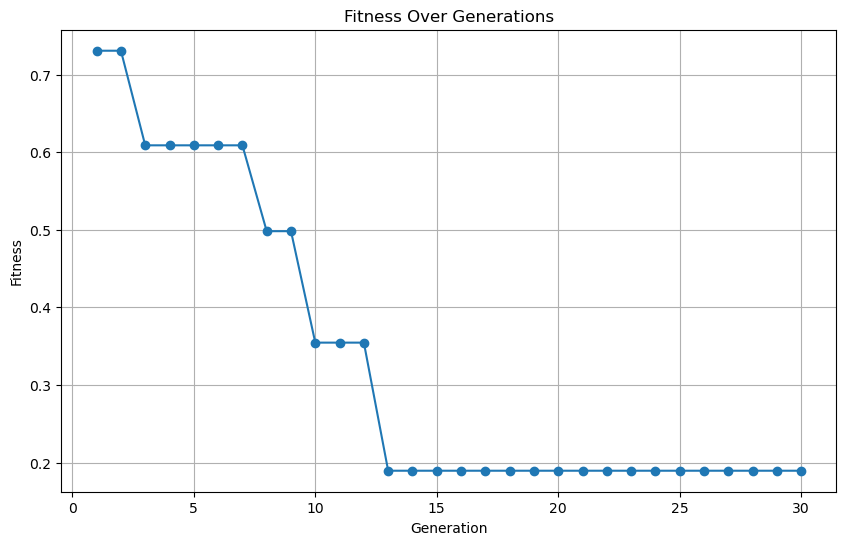

In [2517]:
plot_fitness_history(fitness_history)

In [2518]:
describe_league(best_solution)


League Rating Standard Deviation (fitness): 0.1895

Best League Configuration:

Team 3 (Avg Rating: 86.43, Total Cost: 667.00)
  GK  - Blake Henderson | Rating: 87  | Cost: 95
  DEF - Owen Parker     | Rating: 88  | Cost: 100
  DEF - Ethan Howard    | Rating: 80  | Cost: 70
  MID - Nathan Wright   | Rating: 92  | Cost: 120
  MID - Dominic Bell    | Rating: 86  | Cost: 95
  FWD - Chase Murphy    | Rating: 86  | Cost: 95
  FWD - Zachary Nelson  | Rating: 86  | Cost: 92

Team 0 (Avg Rating: 86.71, Total Cost: 710.00)
  GK  - Chris Thompson  | Rating: 80  | Cost: 80
  DEF - Logan Brooks    | Rating: 86  | Cost: 95
  DEF - Lucas Bennett   | Rating: 85  | Cost: 90
  MID - Ashton Phillips | Rating: 90  | Cost: 110
  MID - Dylan Morgan    | Rating: 91  | Cost: 115
  FWD - Sebastian Perry | Rating: 95  | Cost: 150
  FWD - Tyler Jenkins   | Rating: 80  | Cost: 70

Team 2 (Avg Rating: 86.29, Total Cost: 685.00)
  GK  - Ryan Mitchell   | Rating: 83  | Cost: 85
  DEF - Brayden Hughes  | Rating: 87

Interpretation (for graphs where convergence is really quick):

- There's a big drop in fitness from generation 0 to around 3–5. This means the GA quickly found a much more balanced league early on.
- Flat Line After That, the curve plateaus completely. This suggests the algorithm converged early and didn't improve further.

What this means?

- It found a valid and quite balanced league early. Crossover and mutation might not be exploring much new territory after a few generations.
- Small search space: With only 35 players and tight constraints (unique players, positions), there might not be many drastically different valid solutions.
- Population might be losing diversity too quickly and finding a local minimum instead of global.

Improvement Suggestions:

- Add diversity: increase mutation rate slightly (e.g. 0.3) or try multiple types per generation.
- Change selection: use roulette selection or random elite + one random instead of fixed top-5.
- We want to encourage more progressive convergence.

Interpretation (for graphs where convergence is progressive):

- Initial fitness is relatively high (~0.39), meaning there was significant imbalance between teams at first.
- However, we see progressive drop over generations. Noticeable improvements around generations 3, 10, 17, and 28. After generation 28, fitness plateaus around 0.16, indicating convergence.

What this means?
- The algorithm steadily refined the solution over time likely a larger or more complex search space with more variability in ratings or team structures.
- Mutation and crossover are doing some meaningful exploration, but the population still converges, possibly to a local optimum.

# Comparing with other algorithms

##### `Hill Climbing`

This is a simple, local search algorithm used to solve optimization problems. The main idea is to iteratively improve a solution by making local changes, with the goal of finding a better (usually global) optimal solution.

In [2519]:
def hill_climbing(players, max_iterations=1000, stagnation_limit=100):
    current = TeamAssignmentSolution(players)
    current.random_initial_representation()
    current_fitness = current.fitness()
    
    best_solution = copy.deepcopy(current)
    best_fitness = current_fitness
    fitness_history = [best_fitness]

    stagnation_counter = 0

    for iteration in range(max_iterations):
        # Make a small mutation
        neighbor = copy.deepcopy(current)
        mutation_method = random.choice([
            mutate_swap_same_position,
            skill_balance_mutation,
            mutate_swap_two_players,
            mutate_swap_based_on_cost
        ])
        mutation_method(neighbor)

        neighbor_fitness = neighbor.fitness()

        # Accept the new solution if it's better
        if neighbor_fitness < current_fitness:
            current = neighbor
            current_fitness = neighbor_fitness
            if current_fitness < best_fitness:
                best_solution = copy.deepcopy(current)
                best_fitness = current_fitness
                stagnation_counter = 0
        else:
            stagnation_counter += 1

        fitness_history.append(best_fitness)

        print(f"Iteration {iteration + 1}: Best Fitness = {best_fitness:.4f}")

        # Stop early if no improvements
        if stagnation_counter >= stagnation_limit:
            print(f"[Stopped early] No improvement in last {stagnation_limit} iterations.")
            break

    return best_solution, fitness_history


##### `Simulated Annealing`

Simulated Annealing is a probabilistic optimization algorithm inspired by the physical process of heating and then slowly cooling a material to decrease defects, thereby minimizing the system's energy. It’s often used for optimization problems where the search space is large and contains many local minima. The algorithm uses a "temperature" parameter that controls how much the algorithm allows for exploring worse solutions (higher energy). At the beginning of the process, the temperature is high, allowing the algorithm to accept worse solutions. Over time, the temperature decreases, and the algorithm becomes more conservative.

In [2520]:
def simulated_annealing(players, initial_temp=100.0, cooling_rate=0.95, min_temp=0.01, max_iterations=1000):
    # Start from a random initial solution
    current_solution = TeamAssignmentSolution(players)
    current_solution.random_initial_representation()
    current_fitness = current_solution.fitness()

    best_solution = copy.deepcopy(current_solution)
    best_fitness = current_fitness

    fitness_history = [current_fitness]
    temp = initial_temp

    for iteration in range(max_iterations):
        if temp < min_temp:
            break

        # Generate a neighbor (mutate current solution slightly)
        neighbor = copy.deepcopy(current_solution)
        mutation = random.choice([
            mutate_swap_same_position,
            skill_balance_mutation,
            mutate_swap_two_players,
            mutate_swap_based_on_cost
        ])
        mutation(neighbor)
        neighbor_fitness = neighbor.fitness()

        # Decide whether to accept the neighbor
        delta = neighbor_fitness - current_fitness

        if delta < 0 or random.random() < math.exp(-delta / temp):
            current_solution = neighbor
            current_fitness = neighbor_fitness

            if current_fitness < best_fitness:
                best_solution = copy.deepcopy(current_solution)
                best_fitness = current_fitness

        fitness_history.append(best_fitness)
        temp *= cooling_rate  # Cool down

        if iteration % 100 == 0 or iteration == max_iterations - 1:
            print(f"[SA] Iteration {iteration}: Best Fitness = {best_fitness:.4f}")

    return best_solution, fitness_history

In [2521]:
# Run GA
ga_solution, ga_history = genetic_algorithm(players, generations=100) # increase generations because others run for more iterations as well
ga_fitness = ga_solution.fitness()
# Run Hill Climbing
hc_solution, hc_history = hill_climbing(players)
hc_fitness = hc_solution.fitness()
# Run SA
sa_solution, sa_history = simulated_annealing(players)
sa_fitness = sa_solution.fitness()

Generation 1: Best Fitness = 0.9098

Fitness before mutation: 1.0857142857142859

Skill variances before mutation:
Team 1: Skill Variance = 11.55
Team 4: Skill Variance = 11.71
Team 0: Skill Variance = 9.63
Team 3: Skill Variance = 12.69
Team 2: Skill Variance = 30.00

Swapped players between Team 2 and Team 0 at position GK
Player Chris Thompson (Skill: 80) swapped with Player Alex Carter (Skill: 85)

Skill variances after mutation:
Team 1: Skill Variance = 11.55
Team 4: Skill Variance = 11.71
Team 0: Skill Variance = 13.10
Team 3: Skill Variance = 12.69
Team 2: Skill Variance = 23.06

Fitness after mutation: 1.3684491445517772
Fitness increased — Reverting the mutation.
Generation 2: Best Fitness = 0.9187
Swapping Player: Mason Reed (Cost: 75) <-> Brayden Hughes (Cost: 100)

Before Mutation:
Team 4 DEF: ['Jaxon Griffin', 'Mason Reed'] (Total Cost: 645, Avg Skill: 85.00)
Team 0 DEF: ['Maxwell Flores', 'Brayden Hughes'] (Total Cost: 747, Avg Skill: 88.29)

After Mutation:
Team 4 DEF: [

##### `Results (GA, HC, SA)`

In [2522]:
print("\n=== Fitness Summary ===")
print(f"Genetic Algorithm Best Fitness: {ga_fitness:.4f}")
print(f"Hill Climbing Best Fitness    : {hc_fitness:.4f}")
print(f"Simulated Annealing Fitness   : {sa_fitness:.4f}")


=== Fitness Summary ===
Genetic Algorithm Best Fitness: 0.1400
Hill Climbing Best Fitness    : 0.0571
Simulated Annealing Fitness   : 0.1400


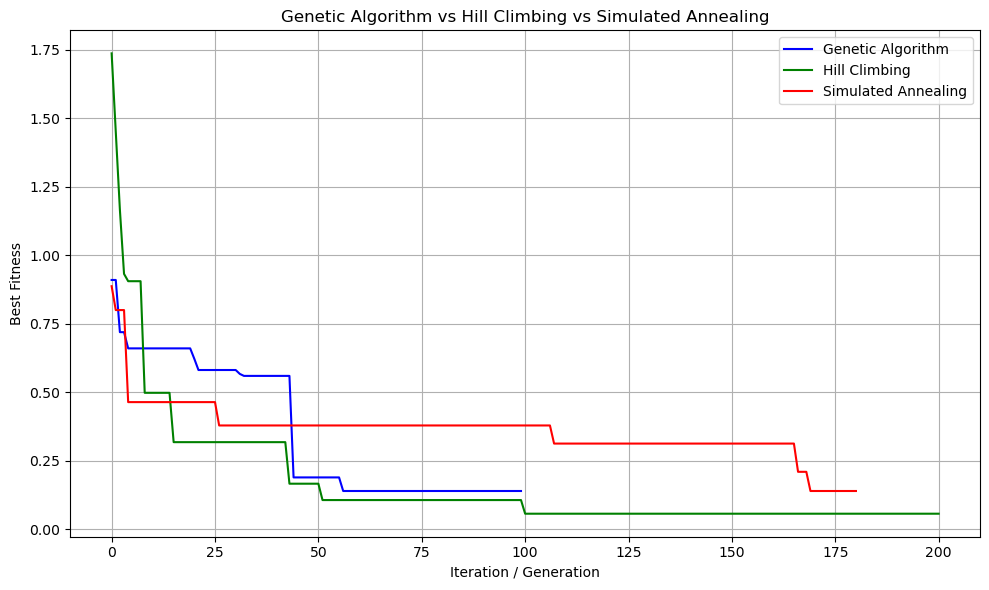

In [2523]:
plt.figure(figsize=(10, 6))

plt.plot(ga_history, label="Genetic Algorithm", color="blue")
plt.plot(hc_history, label="Hill Climbing", color="green")
plt.plot(sa_history, label="Simulated Annealing", color="red")

plt.xlabel("Iteration / Generation")
plt.ylabel("Best Fitness")
plt.title("Genetic Algorithm vs Hill Climbing vs Simulated Annealing")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()